In [9]:
import cv2

# Load the video
video_path = 'sample video.mp4'
cap = cv2.VideoCapture(video_path)

# Check if the video is loaded
if not cap.isOpened():
    print("Error: Could not open video.")

#step 2:  Detect Person Using Background Subtraction
# Create the background subtractor object
backSub = cv2.createBackgroundSubtractorMOG2()

# Define a minimum contour area to filter out noise and small objects
min_contour_area = 7500  # This can be adjusted based on video resolution and target size

#step3 : Define a Function to Extract Appearance Features

while True:
    # Read the next frame
    ret, frame = cap.read()
    if not ret or frame is None:  # Check for None or invalid frame
        break

    # Apply background subtraction
    fg_mask = backSub.apply(frame)

    # Threshold the mask to binarize it
    _, thresh = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)

    # Find contours of the detected objects
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        if cv2.contourArea(contour) < min_contour_area:
            continue

        # Calculate bounding box and centroid
        x, y, w, h = cv2.boundingRect(contour)
        M = cv2.moments(contour)
        if M['m00'] == 0:
            continue
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        # Draw bounding box and label
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)
        cv2.putText(frame, 'Person', (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Show the frame with drawn boxes and labels
    cv2.imshow('Frame', frame)

    # Exit on pressing 'ESC'
    if cv2.waitKey(30) & 0xFF == 27:  
        break

# Release resources
cap.release()
cv2.destroyAllWindows()



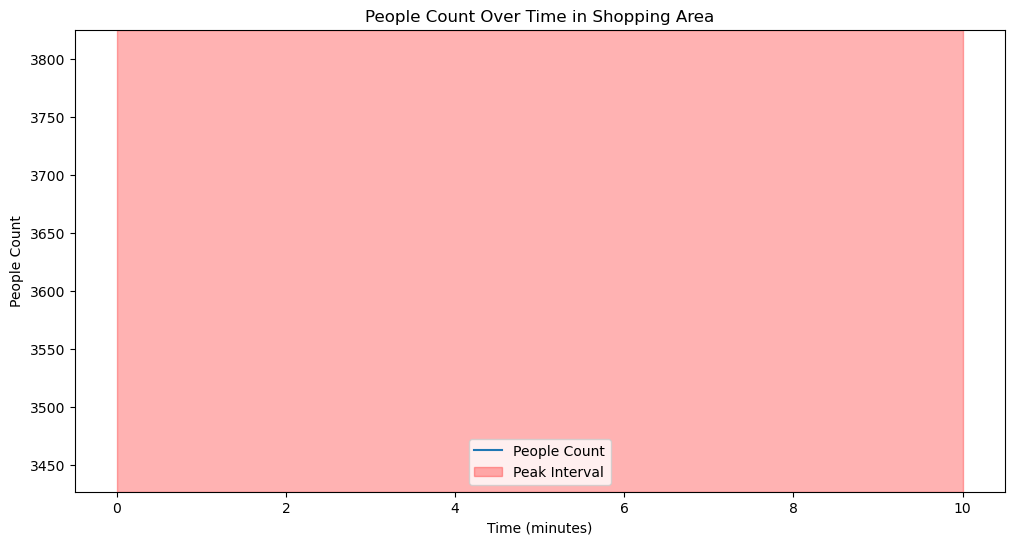

In [5]:
#Task 2 :
#step 1 :
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# Load the video file
# Load the video file
video_path = 'sample video task 2.mp4'
cap = cv2.VideoCapture(video_path)

# Check if the video was loaded successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Initialize background subtractor
backSub = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50)

# Extract FPS before releasing the video
fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
interval_duration = 600  # 10 minutes in seconds
frames_per_interval = int(fps * interval_duration)

# Continue with the people detection as before
# Define a list to store the number of detected people per frame
people_count_per_frame = []

# Minimum area for a contour to be considered as a person
min_contour_area = 1000 # Adjust based on resolution and typical person size in the video

while True:
    ret, frame = cap.read()
    if not ret or frame is None:
        break

    # Apply background subtraction
    fg_mask = backSub.apply(frame)

    # Apply thresholding to get a binary image
    _, thresh = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)

    # Find contours of the detected regions
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Count the number of people in the current frame
    people_count = 0
    for contour in contours:
        if cv2.contourArea(contour) < min_contour_area:
            continue
        people_count += 1

    # Append the count for this frame
    people_count_per_frame.append(people_count)

cap.release()

# Step 3: Calculate the number of people in each interval
people_count_intervals = []
for i in range(0, len(people_count_per_frame), frames_per_interval):
    interval_count = sum(people_count_per_frame[i:i + frames_per_interval])
    people_count_intervals.append(interval_count)

# Find the peak interval
peak_interval_index = np.argmax(people_count_intervals)
peak_interval_count = people_count_intervals[peak_interval_index]
peak_start_frame = peak_interval_index * frames_per_interval
peak_end_frame = peak_start_frame + frames_per_interval

# Convert frames to time for peak interval
peak_start_time = peak_start_frame / fps
peak_end_time = peak_end_frame / fps

# Step 4: Plot the results
plt.figure(figsize=(12, 6))
time_intervals = [i * interval_duration / 60 for i in range(len(people_count_intervals))]  # Convert to minutes
plt.plot(time_intervals, people_count_intervals, label="People Count")
plt.axvspan(peak_start_time / 60, peak_end_time / 60, color='red', alpha=0.3, label="Peak Interval")
plt.xlabel("Time (minutes)")
plt.ylabel("People Count")
plt.title("People Count Over Time in Shopping Area")
plt.legend()
plt.show()




In [1]:
#Task 3
import cv2

# Load the reference image and the video with the provided paths
reference_image = cv2.imread('sample image task 3.jpg', cv2.IMREAD_GRAYSCALE)
video_capture = cv2.VideoCapture('sample video task 3.mp4')

# Load the Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Function to extract facial features using edge detection
def extract_edge_features(image):
    resized_image = cv2.resize(image, (100, 100))  # Resize to 100x100
    edges = cv2.Canny(resized_image, 100, 200)
    return edges.flatten()

# Function to compare facial features
def compare_features(features1, features2):
    # Use a suitable distance metric (e.g., Euclidean distance)
    distance = cv2.norm(features1, features2)
    return distance

# Main loop to process the video
while True:
    # Read a frame from the video
    ret, frame = video_capture.read()
    if not ret:
        break

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Process each detected face
    for (x, y, w, h) in faces:
        # Extract the face region
        face_roi = gray[y:y+h, x:x+w]

        # Extract facial features from the detected face
        face_features = extract_edge_features(face_roi)

        # Extract facial features from the reference image
        reference_features = extract_edge_features(reference_image)

        # Compare the features
        distance = compare_features(face_features, reference_features)

        # Check if the distance is below a threshold (adjust as needed)
        if distance < 10000:  # You may need to adjust this threshold
            # Highlight the matched face
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, "Matched face", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow("Facial Recognition", frame)

    

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and destroy all windows
video_capture.release()
cv2.destroyAllWindows()

In [11]:
#Task 4 
import cv2
import numpy as np

# Load the video with the provided path
video_capture = cv2.VideoCapture('sample video task 4.mp4')

# Define the region of interest (ROI) - Adjust these values
roi_x, roi_y, roi_width, roi_height = 100, 200, 300, 100  
# Create a mask for the ROI
mask = np.zeros_like(cv2.cvtColor(video_capture.read()[1], cv2.COLOR_BGR2GRAY))
cv2.rectangle(mask, (roi_x, roi_y), (roi_x + roi_width, roi_y + roi_height), 255, -1)

# Initialize variables
previous_frame = None
entering_count = 0
exiting_count = 0

while True:
    # Read a frame from the video
    ret, frame = video_capture.read()
    if not ret:
        break

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply the mask to focus on the ROI
    gray = cv2.bitwise_and(gray, gray, mask=mask)

    # If this is the first frame, initialize the previous frame
    if previous_frame is None:
        previous_frame = gray
        continue

    # Calculate the absolute difference between the current and previous frame
    frame_delta = cv2.absdiff(previous_frame, gray)
    thresh = cv2.threshold(frame_delta, 25, 255, cv2.THRESH_BINARY)[1]

    # Dilate the thresholded image to fill in holes
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours on the thresholded image
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Ignore small contours
        if cv2.contourArea(contour) < 500:
            continue

        # Get the bounding rectangle of the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Calculate the centroid of the contour
        centroid_x = int(x + w / 2)
        centroid_y = int(y + h / 2)

        # Determine direction of motion based on centroid position (adjust logic if needed)
        if centroid_x < roi_x + roi_width / 2:
            entering_count += 1
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green for entering
        else:
            exiting_count += 1
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red for exiting

    # Draw the ROI rectangle
    cv2.rectangle(frame, (roi_x, roi_y), (roi_x + roi_width, roi_y + roi_height), (255, 0, 0), 2)

    # Display the resulting frame
    cv2.imshow("People Counting", frame)

    # Update the previous frame
    previous_frame = gray

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and destroy all windows
video_capture.release()
cv2.destroyAllWindows()

# Print the counts
print("Entering count:", entering_count)
print("Exiting count:", exiting_count)

Entering count: 45
Exiting count: 69


In [15]:
#task 5
import cv2
import numpy as np
import time

# Load the video with the provided path
video_capture = cv2.VideoCapture('sample video task 4.mp4')

# Define the region of interest (ROI) - Adjust these values
roi_x, roi_y, roi_width, roi_height = 100, 200, 300, 100  
# Create a mask for the ROI
mask = np.zeros_like(cv2.cvtColor(video_capture.read()[1], cv2.COLOR_BGR2GRAY))
cv2.rectangle(mask, (roi_x, roi_y), (roi_x + roi_width, roi_y + roi_height), 255, -1)

# Initialize variables
previous_frame = None
dwelling_times = {}  # Dictionary to store dwelling times for each object ID

# Create a background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

while True:
    # Read a frame from the video
    ret, frame = video_capture.read()
    if not ret:
        break

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply background subtraction
    fgmask = fgbg.apply(gray)

    # Apply the mask to focus on the ROI
    fgmask = cv2.bitwise_and(fgmask, fgmask, mask=mask)

    # Threshold the foreground mask
    thresh = cv2.threshold(fgmask, 25, 255, cv2.THRESH_BINARY)[1]

    # Dilate the thresholded image to fill in holes
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours on the thresholded image
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Ignore small contours
        if cv2.contourArea(contour) < 500:
            continue

        # Get the bounding rectangle of the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Calculate the centroid of the contour
        centroid_x = int(x + w / 2)
        centroid_y = int(y + h / 2)

        # Create a unique ID for each object based on its centroid position
        object_id = (centroid_x, centroid_y)

        # If the object is not in the dwelling_times dictionary, add it
        if object_id not in dwelling_times:
            dwelling_times[object_id] = {'start_time': time.time(), 'total_time': 0}

        # Update the total dwelling time for the object
        dwelling_times[object_id]['total_time'] = time.time() - dwelling_times[object_id]['start_time']

        # Draw the bounding box and display dwelling time
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, f"ID: {object_id}, Time: {dwelling_times[object_id]['total_time']:.2f}s", 
                    (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Draw the ROI rectangle
    cv2.rectangle(frame, (roi_x, roi_y), (roi_x + roi_width, roi_y + roi_height), (255, 0, 0), 2)

    # Display the resulting frame
    cv2.imshow("Dwelling Time", frame)

    # Update the previous frame (for background subtraction)
    previous_frame = gray

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and destroy all windows
video_capture.release()
cv2.destroyAllWindows()

# Print the dwelling times for each object
print("Dwelling Times:")
for object_id, data in dwelling_times.items():
    print(f"Object ID: {object_id}, Total Time: {data['total_time']:.2f} seconds")

Dwelling Times:
Object ID: (250, 250), Total Time: 23.74 seconds
Object ID: (157, 290), Total Time: 0.00 seconds
Object ID: (213, 283), Total Time: 0.00 seconds
Object ID: (243, 275), Total Time: 0.00 seconds
Object ID: (135, 262), Total Time: 0.00 seconds
Object ID: (305, 266), Total Time: 0.00 seconds
Object ID: (189, 241), Total Time: 0.00 seconds
Object ID: (380, 258), Total Time: 0.00 seconds
Object ID: (285, 228), Total Time: 0.00 seconds
Object ID: (148, 221), Total Time: 0.00 seconds
Object ID: (191, 285), Total Time: 0.00 seconds
Object ID: (296, 252), Total Time: 0.00 seconds
Object ID: (237, 235), Total Time: 0.00 seconds
Object ID: (326, 250), Total Time: 0.02 seconds
Object ID: (146, 222), Total Time: 0.02 seconds
Object ID: (187, 287), Total Time: 0.00 seconds
Object ID: (297, 252), Total Time: 0.00 seconds
Object ID: (237, 232), Total Time: 0.00 seconds
Object ID: (299, 270), Total Time: 0.00 seconds
Object ID: (382, 250), Total Time: 0.00 seconds
Object ID: (287, 270), 

In [1]:
import cv2
import numpy as np

# Load the video
video_capture = cv2.VideoCapture('sample video task 6.mp4')

# Load the template image and handle loading errors
template = cv2.imread('sample  image task 6.png', cv2.IMREAD_GRAYSCALE)
if template is None:
    print("Error: Could not load template image.")
    exit()

# Resize template
template = cv2.resize(template, (50, 50))  
template_w, template_h = template.shape[::-1]

# Initialize variables
car_count = 0
fgbg = cv2.createBackgroundSubtractorMOG2()

while True:
    # Read a frame from the video
    ret, frame = video_capture.read()
    if not ret:
        break

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply background subtraction
    fgmask = fgbg.apply(gray)

    # Threshold and dilate the foreground mask
    thresh = cv2.threshold(fgmask, 25, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.dilate(thresh, None, iterations=3)

    # Find contours
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Ignore small contours
        if cv2.contourArea(contour) < 500:
            continue

        # Get the bounding rectangle of the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Ensure the ROI is at least as large as the template
        if w >= template_w and h >= template_h:
            # Extract the region of interest (ROI) for the car
            car_roi = gray[y:y + h, x:x + w]

            # Perform template matching
            res = cv2.matchTemplate(car_roi, template, cv2.TM_CCOEFF_NORMED)
            threshold = 0.8
            loc = np.where(res >= threshold)

            # If a match is found
            if len(loc[0]) > 0:
                car_count += 1

                # Draw a bounding box around the detected car
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # Draw the template location on the car ROI
                for pt in zip(*loc[::-1]):
                    cv2.rectangle(frame, (x + pt[0], y + pt[1]), (x + pt[0] + template_w, y + pt[1] + template_h), (0, 0, 255), 2)

    # Display the resulting frame
    cv2.imshow("Branded Car Detection", frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and destroy all windows
video_capture.release()
cv2.destroyAllWindows()

# Print the total count
print("Total branded cars detected:", car_count)


Total branded cars detected: 0


In [25]:
import cv2
import numpy as np

# Load the video
video_capture = cv2.VideoCapture('sample video task 6.mp4')

# Initialize background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=100, detectShadows=True)

# Set minimum area for detected contours to be considered as a vehicle
min_contour_area = 50000

# Loop through each frame in the video
while True:
    # Read the current frame
    ret, frame = video_capture.read()
    if not ret:
        break

    # Apply the background subtractor to get the foreground mask
    fgmask = fgbg.apply(frame)

    # Remove shadows by thresholding
    _, fgmask = cv2.threshold(fgmask, 250, 255, cv2.THRESH_BINARY)

    # Dilate the mask to fill in holes and make contours more consistent
    fgmask = cv2.dilate(fgmask, None, iterations=2)

    # Find contours on the thresholded foreground mask
    contours, _ = cv2.findContours(fgmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Ignore small contours that could be noise
        if cv2.contourArea(contour) < min_contour_area:
            continue

        # Get the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Draw bounding box around the detected vehicle
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Display "Vehicle Detected" text above the bounding box
        cv2.putText(frame, "Branded car Detected", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the frame with detected vehicles
    cv2.imshow("Branded carr Detection", frame)

    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
video_capture.release()
cv2.destroyAllWindows()
